In [0]:
import matplotlib.pyplot as plt
import numpy as np


%load_ext autoreload
%autoreload 2

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18432, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=136, bias=True)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.2)
  (drop3): Dropout(p=0.25)
  (drop4): Dropout(p=0.25)
  (drop5): Dropout(p=0

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor


data_transform = transforms.Compose([Rescale(250) , RandomCrop(224),Normalize() , ToTensor()])

assert(data_transform is not None), 'Define a data_transform'

In [0]:

transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

print('Number of images: ', len(transformed_dataset))

for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


In [0]:
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [0]:

test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [0]:
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [0]:

def net_sample_output():
    for i, sample in enumerate(test_loader):
        images = sample['image']
        key_pts = sample['keypoints']
        images = images.type(torch.FloatTensor)
        output_pts = net(images)
        
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        if i == 0:
            return images, output_pts, key_pts
            

In [0]:
test_images, test_outputs, gt_pts = net_sample_output()
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):

    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


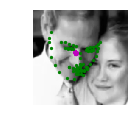

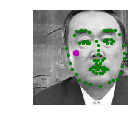

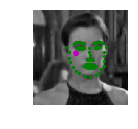

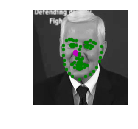

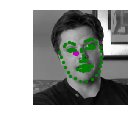

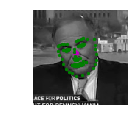

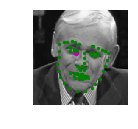

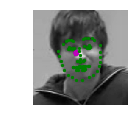

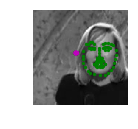

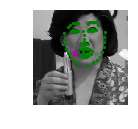

In [0]:

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        image = test_images[i].data   
        image = image.numpy()   
        image = np.transpose(image, (1, 2, 0))   

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts*50.0+100
        
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
visualize_output(test_images, test_outputs, gt_pts)

In [0]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr = 0.001)


In [0]:
def train_net(n_epochs):

    net.train()

    for epoch in range(n_epochs):  
        
        running_loss = 0.0

        for batch_i, data in enumerate(train_loader):
            images = data['image']
            key_pts = data['keypoints']

          
            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            output_pts = net(images)

            loss = criterion(output_pts, key_pts)

            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            if batch_i % 10 == 9:    
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [0]:
n_epochs = 1 


with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2762748382985592
Epoch: 1, Batch: 20, Avg. Loss: 0.1251022197306156
Epoch: 1, Batch: 30, Avg. Loss: 0.1069267138838768
Epoch: 1, Batch: 40, Avg. Loss: 0.10606576725840569
Epoch: 1, Batch: 50, Avg. Loss: 0.09613709561526776
Epoch: 1, Batch: 60, Avg. Loss: 0.10401231124997139
Epoch: 1, Batch: 70, Avg. Loss: 0.13341194912791252
Epoch: 1, Batch: 80, Avg. Loss: 0.09145402535796165
Epoch: 1, Batch: 90, Avg. Loss: 0.09498897306621075
Epoch: 1, Batch: 100, Avg. Loss: 0.10482842773199082
Epoch: 1, Batch: 110, Avg. Loss: 0.10012543126940728
Epoch: 1, Batch: 120, Avg. Loss: 0.09390917830169201
Epoch: 1, Batch: 130, Avg. Loss: 0.09387591443955898
Epoch: 1, Batch: 140, Avg. Loss: 0.09120967164635659
Epoch: 1, Batch: 150, Avg. Loss: 0.10059340000152588
Epoch: 1, Batch: 160, Avg. Loss: 0.09927746765315533
Epoch: 1, Batch: 170, Avg. Loss: 0.11310853771865367
Epoch: 1, Batch: 180, Avg. Loss: 0.0968516007065773
Epoch: 1, Batch: 190, Avg. Loss: 0.0898839257657528
Epoch: 

In [0]:
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


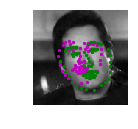

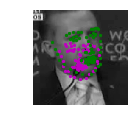

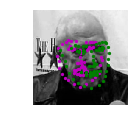

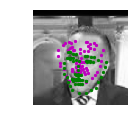

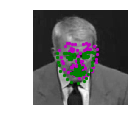

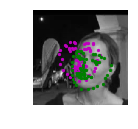

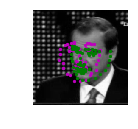

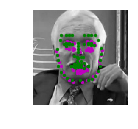

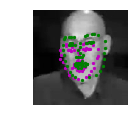

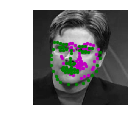

In [0]:
visualize_output(test_images, test_outputs, gt_pts)


In [0]:
model_dir = 'saved_models/'
model_name = 'final_keypoint_model.pt'

torch.save(net.state_dict(), model_dir+model_name)

[[ 0.12346834 -0.0305162   0.0376824  -0.05049655  0.18395776]
 [ 0.16471043 -0.14024431  0.0127453   0.03857663 -0.07789499]
 [ 0.15462768 -0.1704012   0.01635799 -0.04894589 -0.19626302]
 [-0.02248365 -0.07859103  0.04796025 -0.16069536 -0.08668675]
 [ 0.18767159 -0.10420248 -0.10403617  0.15721865  0.08030815]]
(5, 5)


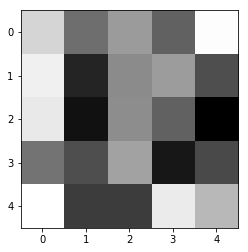

In [0]:

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# displays the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


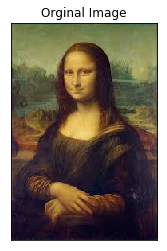

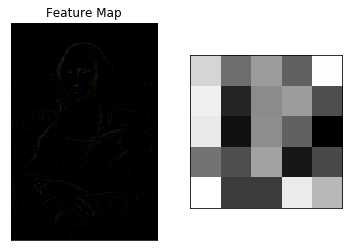

In [0]:
import cv2
image = cv2.imread('./images/mona_lisa.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.xticks([]), plt.yticks([])
plt.title("Orginal Image")

filtered = cv2.filter2D(image, -1, w[filter_index][0])

fig = plt.figure()
ax = fig.add_subplot(121, xticks = [], yticks = [])
ax.imshow(filtered)
ax.set_title("Feature Map")
ax = fig.add_subplot(122, xticks = [], yticks = [])
ax.imshow(w[filter_index][0], cmap = 'gray')

plt.show()